In [1]:
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor

import cv2
import skimage
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot
from itertools import product
from sklearn.cluster import MeanShift

from IPython.display import Video, HTML

In [2]:
def create_video(save_dir, size, img_format='jpg', vido_format='avi'):
    out_name = Path(save_dir).parts[-1]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(Path(save_dir) / Path(f'{out_name}.{vido_format}')),
                          fourcc, 20, tuple(size.astype(int)))

    for fname in tqdm(sorted(map(str, Path(save_dir).glob(f'*.{img_format}')))):
        imag = skimage.io.imread(fname)
        out.write(imag)
    out.release()

def get_video_details(cap):
    cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)

    print(cnt, w, h, fps)
    return w, h

## Оптический поток

In [3]:
video = 'shibuya.mp4'
Video(video)

In [117]:
def show_optic_flow(videopath, to_skip=200):
    color = (0, 255, 0)
    
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    cap = cv2.VideoCapture(videopath)
    w, h = get_video_details(cap)

    for _ in range(to_skip):
        cap.read()
    _, first_frame = cap.read()
    _, second_frame = cap.read()

    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(second_frame, cv2.COLOR_BGR2GRAY)

    step = 5
    grid = np.array(list(product(np.arange(0, w, step, dtype=np.float32), np.arange(0, h, step, dtype=np.float32)))).astype(np.float32)

    tracked_changes = np.zeros_like(first_frame)

    next, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, grid, None, **lk_params)
    status = status.squeeze()
    print(grid.shape, next.shape, status.shape, np.sum(status))
    # for x, y in grid:
    #     cv2.circle(tracked_changes, (int(x), int(y)), 1, (255, 127, 127), -1)
    # for x, y in next:
    #     cv2.circle(tracked_changes, (int(x), int(y)), 1, (255, 255, 255), -1)

    for (x1, y1), (x2, y2) in zip(grid[status == 1], next[status == 1]):
        cv2.arrowedLine(tracked_changes, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 255), 1)
    
    fg, ax = pyplot.subplots(1, 2, figsize=(18, 12))
    ax[0].imshow(first_frame[..., ::-1])
    ax[1].imshow(second_frame[..., ::-1])
    pyplot.show()
    fg = pyplot.figure(figsize=(8, 6))
    pyplot.imshow(tracked_changes)
    pyplot.show()
    


877.0 1280.0 720.0 25.0
(36864, 2) (36864, 2) (36864,) 34914


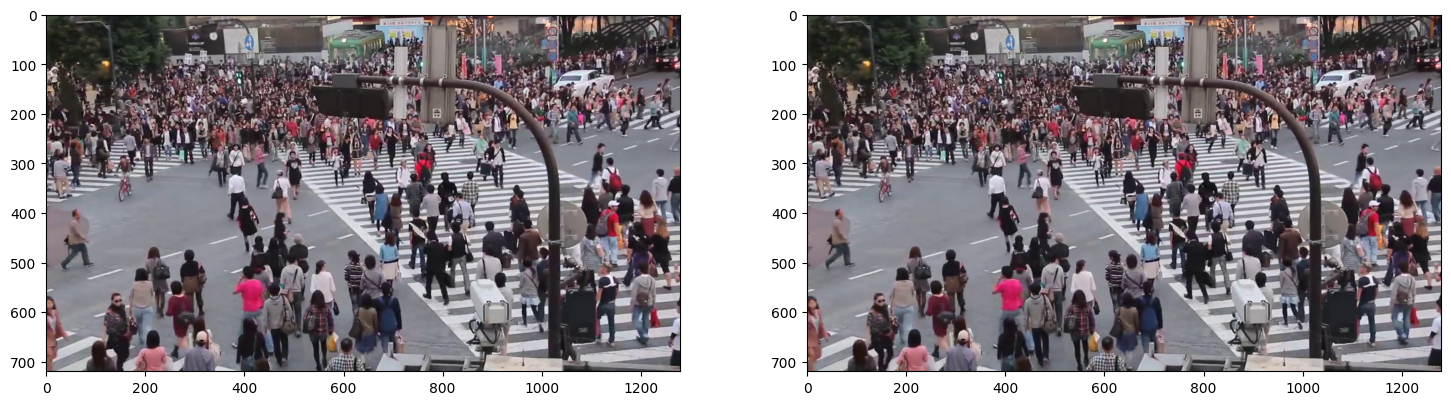

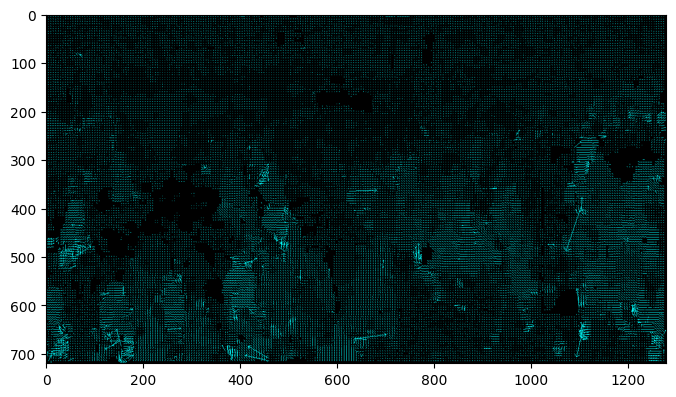

In [118]:
show_optic_flow(video, 200)

877.0 1280.0 720.0 25.0
(36864, 2) (36864, 2) (36864,) 35571


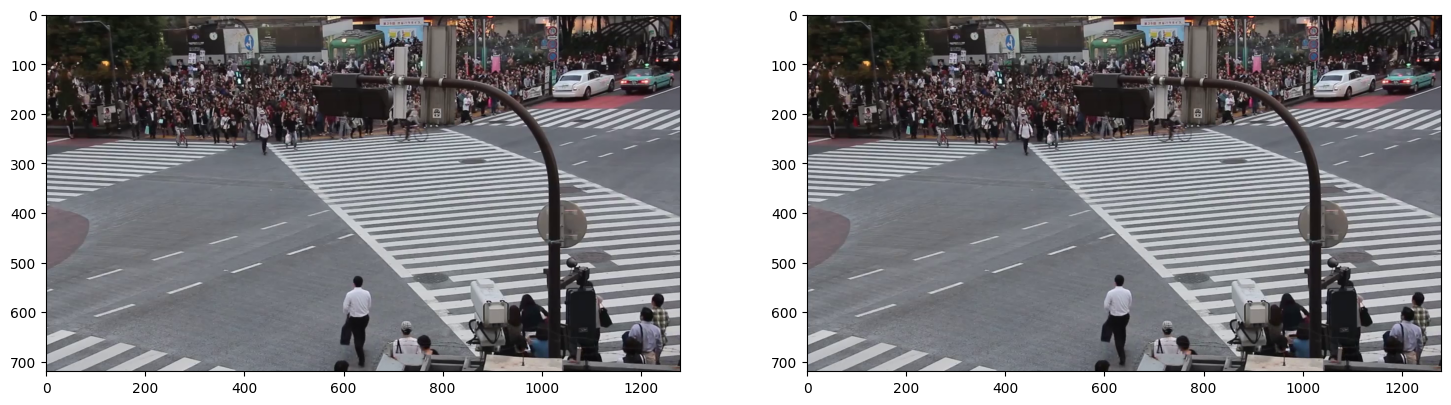

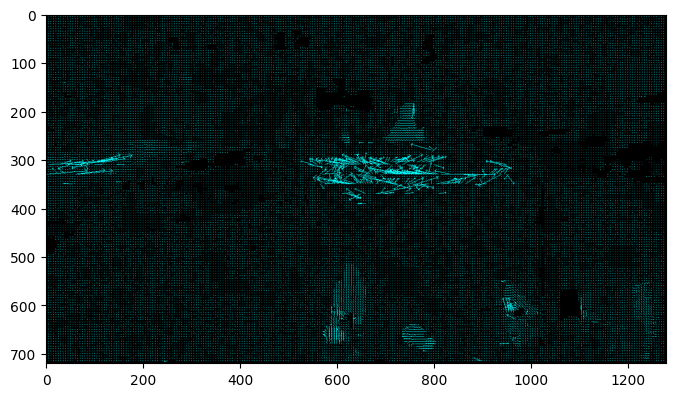

In [119]:
show_optic_flow(video, 2)

## Метод Lukas-Karnade

In [16]:
def sparse_motion(videopath):
    color = (0, 255, 0)

    # Parameters for Shi-Tomasi corner detection
    feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    cap = cv2.VideoCapture(videopath)
    w, h = get_video_details(cap)
    # cv2.startWindowThread()
    # cv2.namedWindow('imageWindow')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(videopath.split('.')[0] + '_spartial.mp4', fourcc, 25, (int(w), int(h)))
    
    is_ok, first_frame = cap.read()

    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    prev = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
    mask = np.zeros_like(first_frame)
    idx = 0
    while (cap.isOpened()):
        is_ok, frame = cap.read()
        if not is_ok:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(frame)

        prev = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
        next, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)

        good_old = prev[status == 1].astype(int)
        good_new = next[status == 1].astype(int)

        # Draws the optical flow tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv2.line(mask, (a, b), (c, d), color, 2)
            frame = cv2.circle(frame, (a, b), 3, color, -1)

        output = cv2.add(frame, mask)
        prev_gray = gray.copy()
        # Updates previous good feature points
        prev = good_new.reshape(-1, 1, 2)

        # Opens a new window and displays the output frame
        out.write(output)
        # cv2.imshow("sparse optical flow", output)
        # cv2.imwrite(f'tmp/frame_{str(idx).zfill(5)}.jpg', output)
        idx += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # The following frees up resources and closes all windows
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [17]:
sparse_motion(video)

877.0 1280.0 720.0 25.0


In [19]:
Video('shibuya_spartial.mp4')

## Метод Horn-Shrunk

In [7]:
def dense_motion(videopath):
    # cap = cv2.VideoCapture("shibuya.mp4")
    cap = cv2.VideoCapture(videopath)
    is_ok, first_frame = cap.read()

    farn_params = dict(pyr_scale=0.5, levels=3, winsize=35,
                       iterations=3, poly_n=5, poly_sigma=1.2,
                       flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

    w, h = get_video_details(cap)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(videopath.split('.')[0] + '_dense.mp4', fourcc, 25, (int(w), int(h)))

    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    mask = np.zeros_like(first_frame)
    mask[..., 1] = 255

    while (cap.isOpened()):
        is_ok, frame = cap.read()
        if not is_ok:
            break
        cv2.imshow("input", frame)

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, **farn_params)

        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])

        mask[..., 0] = angle * 180 / np.pi / 2
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
        out.write(rgb)
        cv2.imshow("dense optical flow", rgb)

        prev_gray = gray

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # The following frees up resources and closes all windows
    out.release()
    cap.release()
    cv2.destroyAllWindows()

In [8]:
dense_motion(video)

877.0 1280.0 720.0 25.0


In [20]:
Video('shibuya_dense.mp4')

## Семантическая Сегментация

In [19]:
video_roads = 'cctv052x2004080617x00071.avi'
Video(video_roads)

In [32]:
def motion_segmentation(videopath):
    color = (0, 255, 0)

    # Parameters for Shi-Tomasi corner detection
    feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    cap = cv2.VideoCapture(videopath)
    w, h = get_video_details(cap)
    # cv2.startWindowThread()
    # cv2.namedWindow('imageWindow')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(videopath.split('.')[0] + 'motion_segmentation.mp4', fourcc, 25, (int(w), int(h)))
    
    is_ok, first_frame = cap.read()

    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    step=5
    grid = np.array(list(product(np.arange(0, w, step, dtype=np.float32), np.arange(0, h, step, dtype=np.float32)))).astype(np.float32)
 
    mask = np.zeros_like(first_frame)
    idx = 0
    while (cap.isOpened()):
        is_ok, frame = cap.read()
        if not is_ok:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(frame)

        next, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, grid, None, **lk_params)

        status = status.squeeze()
        # for x, y in grid:
        #     cv2.circle(tracked_changes, (int(x), int(y)), 1, (255, 127, 127), -1)
        # for x, y in next:
        #     cv2.circle(tracked_changes, (int(x), int(y)), 1, (255, 255, 255), -1)
        
        for (x1, y1), (x2, y2) in zip(grid[status == 1], next[status == 1]):
            if ((x2 - x1) ** 2 + (y2 - y1) ** 2) > 20:
                cv2.circle(mask, (int(x1), int(y1)), 2, (255, 127, 127), -1)
            #cv2.arrowedLine(mask, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 255), 1)
        
            # Opens a new window and displays the output frame
        out.write(mask)
        # cv2.imshow("sparse optical flow", output)
        # cv2.imwrite(f'tmp/frame_{str(idx).zfill(5)}.jpg', output)
        idx += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # The following frees up resources and closes all windows
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    


In [33]:
motion_segmentation(video)

877.0 1280.0 720.0 25.0


In [8]:
def motion_segmentation_from_dense(videopath, densepath):
    color = (0, 255, 0)

    # Parameters for Shi-Tomasi corner detection
    feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    cap = cv2.VideoCapture(videopath)
    cap_dense = cv2.VideoCapture(densepath)
    w, h = get_video_details(cap)
    # cv2.startWindowThread()
    # cv2.namedWindow('imageWindow')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(videopath.split('.')[0] + 'motion_segmentation_on_dense.mp4', fourcc, 25, (int(w), int(h)))

    while (cap.isOpened() and cap_dense.isOpened()):
        is_ok, frame = cap.read()
        is_ok_d, dense_frame = cap_dense.read()
        if not is_ok or not is_ok_d:
            break
        dense_frame = cv2.cvtColor(dense_frame, cv2.COLOR_BGR2HSV)
        mask = dense_frame[..., 2] < 20

        frame[mask] = (0, 0, 0)
        
        out.write(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # The following frees up resources and closes all windows
    cap.release()
    cap_dense.release()
    out.release()
    cv2.destroyAllWindows()
    


In [9]:
motion_segmentation_from_dense('shibuya.mp4', 'shibuya_dense.mp4')

877.0 1280.0 720.0 25.0


## Инстансе Сегментация

In [94]:
def motion_instance_segmentation_from_dense(videopath, densepath, to_skip = 200):
    color = (0, 255, 0)
    
    # Parameters for Shi-Tomasi corner detection
    feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    cap = cv2.VideoCapture(videopath)
    cap_dense = cv2.VideoCapture(densepath)
    w, h = get_video_details(cap)

    for _ in range(to_skip):
        cap.read()
        cap_dense.read()

    is_ok, frame = cap.read()
    is_ok_d, dense_frame = cap_dense.read()

    dense_frame = cv2.cvtColor(dense_frame, cv2.COLOR_BGR2HSV)

    # x = np.arange(w, dtype=np.int32)
    # y = np.arange(h, dtype=np.int32)
    # X, Y = np.meshgrid(x, y)

    # full_data = np.array([Y, X, dense_frame[..., 0], dense_frame[..., 2]]).transpose(1, 2, 0)
    # print(full_data.shape)
    # full_data = np.concatenate(full_data, axis=0)
    # print(full_data.shape)
    # full_data = full_data[full_data[..., 3] > 20][..., :3]
    # print(full_data.shape)

    label_mean_sh = skimage.segmentation.felzenszwalb(dense_frame[..., 0], scale=3000, sigma=0.1, min_size=1000)
    
    # ms = MeanShift(n_jobs=10)
    # ms.fit(full_data)
    # labels = ms.labels_
    
    # mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    # mask[full_data[..., 0], full_data[..., 1]] = labels

    fg, ax = pyplot.subplots(1, 2, figsize=(18, 12))
    ax[0].imshow(frame[..., ::-1])
    ax[1].imshow(cv2.cvtColor(dense_frame, cv2.COLOR_HSV2RGB))
    pyplot.show()
    fg, ax = pyplot.subplots(1, 2, figsize=(18, 12))
    ax[0].imshow(label_mean_sh)
    ax[1].imshow(label_mean_sh == 69)
    pyplot.show()

    # The following frees up resources and closes all windows
    cap.release()
    cap_dense.release()
    cv2.destroyAllWindows()

877.0 1280.0 720.0 25.0


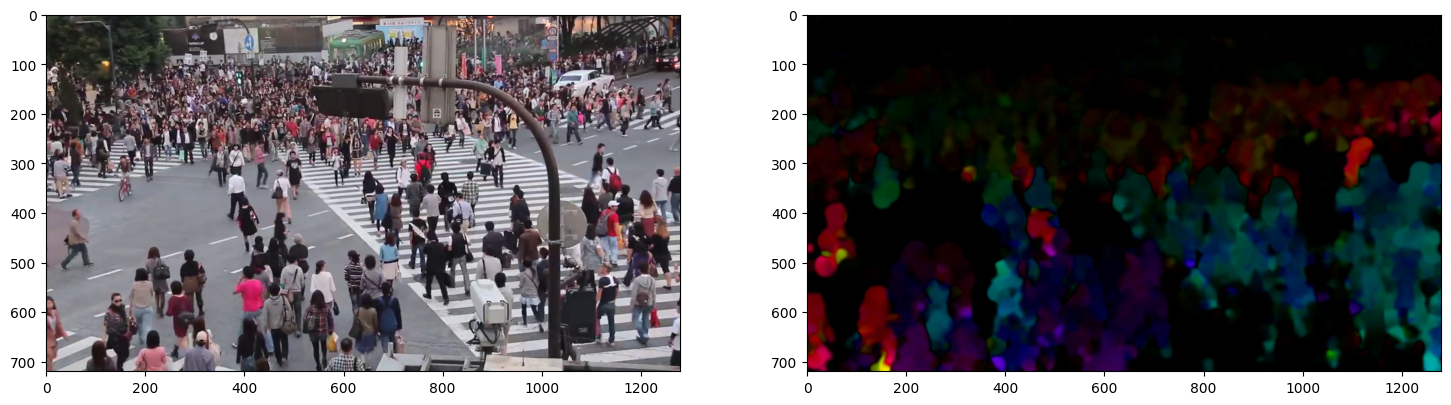

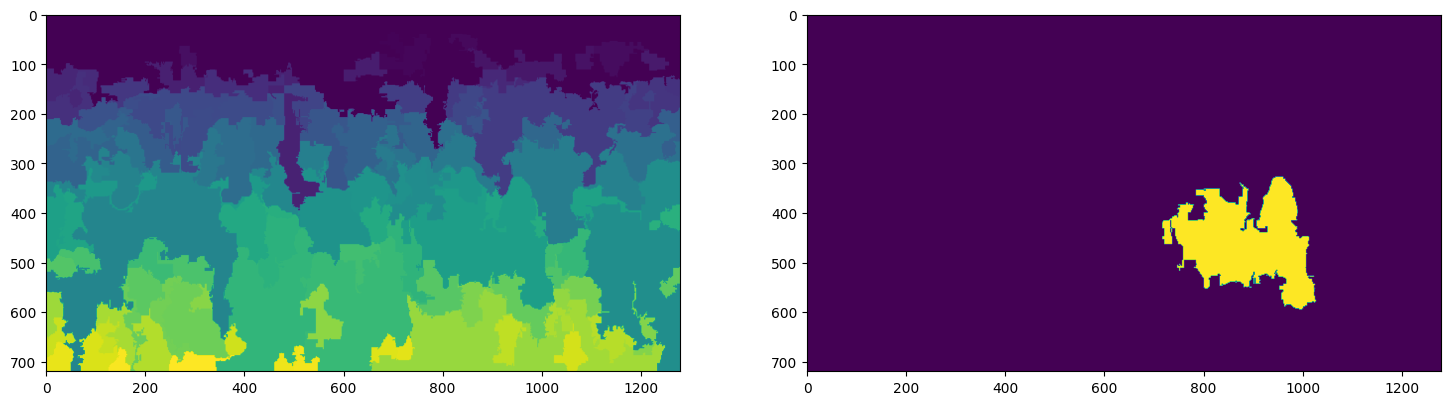

In [95]:
motion_instance_segmentation_from_dense('shibuya.mp4', 'shibuya_dense.mp4')

## Еще больше задач, решаемыех при помощи оптического потока

При помощи оптического потока можно так же:

Создавать динамические текстуры https://vision.csee.wvu.edu/publications/UCLA-CSD-TR020001.pdf

Супер-разрешение изображения https://cvg.cit.tum.de/_media/spezial/bib/mitzel_et_al_dagm09.pdf

Однако такие задачи были вытеснены нейронками, и реализацию уже не получится найти. В качестве опционального ознакомения прикрепил соответствующие статьи. 
